### Importing Libs

In [2]:
import glob
import os
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from IPython import display
from tensorflow.keras import layers

2023-05-22 20:46:11.754796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 20:46:12.361878: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 20:46:12.364035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 20:46:15.804920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
np.random.seed(1)
tf.random.set_seed(1)
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 60
LR = 1e-2
EMBED_DIM = 64 

### Loading data

In [6]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BATCH_SIZE * 4)

2023-05-22 20:48:36.904948: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [10]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32")
test_images = (test_images - 127.5) / 127.5

### Encoder

In [12]:
def make_encoder(embed_dim):
    model = tf.keras.Sequential(name="encoder")
    model.add(
        layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(embed_dim))
    assert model.output_shape == (None, embed_dim)

    return model

### Decoder

In [14]:
def make_decoder(embed_dim):
    model = tf.keras.Sequential(name="decoder")
    model.add(layers.Dense(embed_dim, use_bias=False, input_shape=(embed_dim,)))
    model.add(layers.Dense(6272, use_bias=False, input_shape=(embed_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))

    model.add(
        layers.Conv2DTranspose(
            128, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            1,
            (5, 5),
            strides=(2, 2),
            padding="same",
            use_bias=False,
            activation="tanh",
        )
    )
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Auto encoder 

In [15]:
ae_model = tf.keras.models.Sequential(
    [make_encoder(EMBED_DIM), make_decoder(EMBED_DIM)]
)

In [17]:
ae_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 64)                608064    
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         1047360   
                                                                 
Total params: 1,655,424
Trainable params: 1,642,496
Non-trainable params: 12,928
_________________________________________________________________


In [18]:
make_encoder(EMBED_DIM).summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0   

In [19]:
make_decoder(EMBED_DIM).summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                4096      
                                                                 
 dense_5 (Dense)             (None, 6272)              401408    
                                                                 
 batch_normalization_3 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        409600    
 ranspose)                                                 

### Loss

In [22]:
def loss(model, original):
    reconstruction_error = tf.reduce_mean(
        tf.square(tf.subtract(model(original), original))
    )
    return reconstruction_error

### Optimizer

In [23]:
optimizer = tf.keras.optimizers.SGD(lr=LR)

### Checkpoint

In [24]:
checkpoint_dir = "./ae_training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=ae_model)

### Training Loop

In [25]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        ae_gradients = tape.gradient(
            loss(ae_model, images), ae_model.trainable_variables
        )
    gradient_variables = zip(ae_gradients, ae_model.trainable_variables)

    optimizer.apply_gradients(gradient_variables)

In [26]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(ae_model, epoch + 1, test_images[:16, :, :, :])

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")

    display.clear_output(wait=True)
    generate_and_save_images(ae_model, epochs, test_images[:16, :, :, :])

### Generate and save images

In [27]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        pixels = predictions[i, :, :] * 127.5 + 127.5
        pixels = np.array(pixels, dtype="float")
        pixels = pixels.reshape((28, 28))
        plt.imshow(pixels, cmap="gray")
        plt.axis("off")

    plt.savefig(f"image_at_epoch_{epoch:04d}.png")
    plt.show()

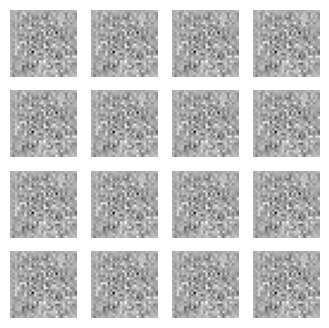

In [28]:
generate_and_save_images(ae_model, 4, test_images[:16, :, :, :])

### Training

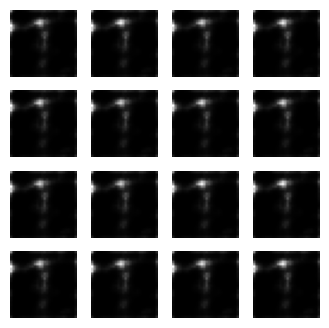

In [30]:
train(train_dataset, EPOCHS)

### Display Image

In [34]:
def display_image(epoch_no):
    return PIL.Image.open(f"./image_at_epoch_{epoch_no:04d}.png")

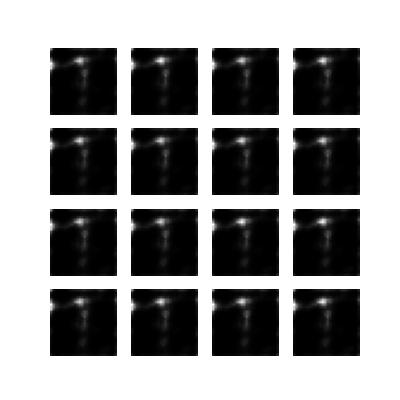

In [35]:
display_image(EPOCHS)

### GIF

In [37]:
anim_file = "autoencoder.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob("./image*.png")
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython

if IPython.version_info > (6, 2, 0, ""):
    display.Image(filename=anim_file)

/tmp/ipykernel_233/3570773250.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_233/3570773250.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


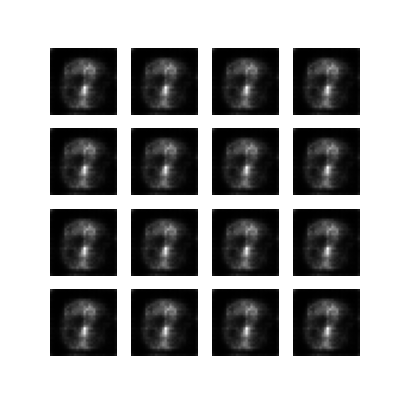

In [38]:
display.Image(filename=anim_file)